In [125]:
%load_ext autoreload
%autoreload 2

from tweedejaars_project import *
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import *
from sklearn.tree import *
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder
import xgboost
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

df = load_df()

print(df)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
                        datetime  import_capacity  upward_dispatch_published  \
0      2023-12-29 00:00:00+00:00             65.4                        0.0   
1      2023-12-29 00:01:00+00:00             65.4                        0.0   
2      2023-12-29 00:02:00+00:00             65.4                        0.0   
3      2023-12-29 00:03:00+00:00             65.4                        0.0   
4      2023-12-29 00:04:00+00:00             65.4                        0.0   
...                          ...              ...                        ...   
220241 2024-05-29 22:41:00+00:00           1982.6                      167.0   
220242 2024-05-29 22:42:00+00:00           1982.6                      165.0   
220243 2024-05-29 22:43:00+00:00           1982.6                      162.0   
220244 2024-05-29 22:44:00+00:00           1982.6                      158.0   
220245 2024-05-29 22:45:00+00:00

In [126]:
def custom_scorer(estimator, X, y):
    try:
        return f1_score(y, estimator.predict(X))
    except Exception as e:
        print(f"Error during scoring: {e}")
        return np.nan

def train(features: pd.DataFrame, target: pd.DataFrame, model, params={}, splits=10):
    """Train a model with grid search"""
    cv = TimeSeriesSplit(n_splits=splits)

    model = GridSearchCV(estimator=model, param_grid=params, scoring='f1',
                         refit=True, cv=cv.split(features), n_jobs=-1, verbose=1)
    model.fit(features, target)
    best_model = model.best_estimator_
    print(model.best_params_)
    train_predictions = best_model.predict(features)

    return np.array(train_predictions), best_model

In [127]:
features = [
    "import_capacity",
    "min_price_published",
    "mid_price_published",
    "max_price_published",
    "upward_dispatch_published",
    "downward_dispatch_published",
    'min_ptu_price_known',
    "max_ptu_price_known",
    "settlement_price_bestguess",
    'naive_strategy_action',
    'PTU',
    'forecast_wind',
    'forecast_solar',
    'forecast_demand',
    'target_two_sided_ptu_realtime',
]

splits = get_splits(df, features=features, return_dict_pair=False)

train_x = splits['train'][0]
train_y = splits['train'][1]

valid_x = splits['valid'][0]
valid_y = splits['valid'][1]
valid_ids = splits['valid'][2]


test_x = splits['test'][0]
test_y = splits['test'][1]
ids = splits['test'][2]

# train_x = df[features][:165195]
# train_y = df['target_two_sided_ptu'][:165195]

# test_x = df[features][165195:]
# test_y = df['target_two_sided_ptu'][165195:]
# ids = df['ptu_id'][165195:]



In [128]:
# Initialize the Decision Tree Classifier
# clf = HistGradientBoostingClassifier()

# # Train the classifier
# clf.fit(train_x, train_y)

# y_pred = clf.predict(test_x)

pipe = Pipeline([
    ('scaler', RobustScaler()),
    # ('svr', xgboost.XGBClassifier(
    #     n_estimators=100, max_depth=7, learning_rate=0.01, subsample=0.8
    #     ))
    ('svr', xgboost.XGBClassifier(
        n_estimators=200, max_depth=7, learning_rate=0.2, subsample=0.8, reg_alpha=0.1,
        reg_lambda=1, gamma=0.2, colsample_bytree=1
        ))
])



# _, model = train(train_x, train_y, pipe, {}, 5)
pipe.fit(train_x, train_y)
save_model(pipe, 'xgboost')


Classification Report:
              precision    recall  f1-score   support

       False       0.95      0.94      0.94     37860
        True       0.46      0.54      0.50      3900

    accuracy                           0.90     41760
   macro avg       0.71      0.74      0.72     41760
weighted avg       0.91      0.90      0.90     41760

Confusion Matrix:


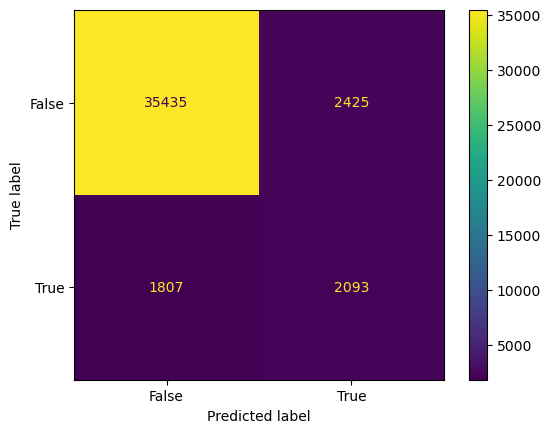

False negative score (pred/max): 0.6441495778045838, 534/829
False positive score (pred/max): 0.17455798621516333, 1165/6674
             neg    pos
count  58.000000  242.0
mean   -9.793103    0.0
std     2.930533    0.0
min   -14.000000    0.0
25%   -12.750000    0.0
50%   -10.000000    0.0
75%    -7.000000    0.0
max    -3.000000    0.0
Time taken (pred/max): -1.8933333333333333/-9.47, using 300/300


In [133]:
model = load_model('xgboost')

y_pred = model.predict(valid_x)
show_basic_metrics(valid_y, y_pred, valid_ids, False)
show_real_penalty_score(valid_x, valid_y, y_pred, valid_ids, example_revenue=False)
show_time_diff_score(valid_x, y_pred, valid_ids)


In [130]:
# def compute_penalty(df, pred, ids):
#     total_penalty = 0

#     pred_df = pd.DataFrame({
#         "ptu_id": ids,
#         "target_two_sided_ptu_pred": pred
#     })
    
#     df = df.set_index("ptu_id")
#     pred_df = pred_df.set_index("ptu_id")
    
#     df["target_two_sided_ptu_pred"] = pred_df["target_two_sided_ptu_pred"]

#     df = df.reset_index()

#     grouped = df.groupby("ptu_id")

#     for _, job_df in grouped:
#         if job_df['target_two_sided_ptu'].any():
#             count = 0
#             positive_found = False

#             job_df = job_df.reset_index(drop=True)

#             for _, row in job_df.iloc[2:].iterrows():
#                 min_price = row["min_price_published"]
#                 max_price = row["max_price_published"]

#                 if min_price < 0 and not positive_found:
#                     count += 1

#                 if row['target_two_sided_ptu']:
#                     if min_price < 0 and not positive_found:
#                         count -= 1

#                 if pd.notna(max_price) and max_price > 0:
#                     positive_found = True

#             max_price = job_df["max_price_published"].max()
#             if pd.notna(max_price):
#                 penalty = ((100 / 60) * max_price).round(-1) * count
#                 total_penalty += penalty

#     return total_penalty

# def compute_reward(df, pred, ids):
#     total_reward = 0

#     pred_df = pd.DataFrame({
#         "ptu_id": ids,
#         "target_two_sided_ptu_pred": pred
#     })
    
#     df = df.set_index("ptu_id")
#     pred_df = pred_df.set_index("ptu_id")
    
#     df["target_two_sided_ptu_pred"] = pred_df["target_two_sided_ptu_pred"]

#     df = df.reset_index()

#     grouped = df.groupby("ptu_id")

#     for _, job_df in grouped:
#         if not job_df['target_two_sided_ptu'].any():

#             job_df = job_df.reset_index(drop=True)

#             if pd.notna(max_price):
#                 reward = ((100 / 60) * min_price).round(-1) * count
#                 total_reward += reward

#     return total_reward

# compute_penalty(df, df['target_two_sided_ptu'], df['ptu_id'])

In [131]:
# def flatten_ptu(true, pred, ids):
#     # Concatenate the true, pred, and ids into a single DataFrame
#     base = pd.concat([pd.Series(true), pd.Series(pred), pd.Series(ids)], axis=1, ignore_index=True)
#     base.columns = ["target_two_sided_ptu", "target_two_sided_ptu_pred", "ptu_id"]

#     # Group by the ptu_id and aggregate the true and pred values
#     # Here we assume you want to flatten using some kind of aggregation, like mean
#     df = base.groupby("ptu_id").agg({
#         "target_two_sided_ptu": "any",
#         "target_two_sided_ptu_pred": "any"
#     }).reset_index()

#     return df

# def basic_metrics(true, pred, ids, flatten=True):
#     if flatten:
#         flattened = flatten_ptu(true, pred, ids)
#         test_y = flattened['target_two_sided_ptu']
#         y_pred = flattened['target_two_sided_ptu_pred']
    
#     accuracy = accuracy_score(true, pred)
#     print(accuracy)
    
#     print("Classification Report:")
#     print(classification_report(true, pred))
    
#     # Print the confusion matrix
#     print("Confusion Matrix:")
#     ConfusionMatrixDisplay.from_predictions(true, pred)
#     plt.show()
        


# basic_metrics(test_y, y_pred, ids, flatten=False)


In [132]:
# data = {
#     'Time': [
#         '11:30', '11:31', '11:32', '11:33', '11:34', '11:35', '11:36', 
#         '11:37', '11:38', '11:39', '11:40', '11:41', '11:42', '11:43', 
#         '11:44', '11:45'
#     ],
#     'min_price_published': [
#         -100, np.NaN, 0, -100, -150, 
#         -200, -300, -100, np.NaN, np.NaN, 
#         np.NaN, np.NaN, np.NaN, -30, -100, 0
#     ],
#     'max_price_published': [
#         np.NaN, 20, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, 
#         40, 50, 90, 200, 80, 
#         np.NaN, np.NaN, np.NaN
#     ],
#     'target_two_sided_ptu': [
#         True, False, False, True, True, False, False, True, False, False,
#          False, False, False, False, False, False
#     ],
#     'ptu_id':
#     [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
# }

# df = pd.DataFrame(data)


# compute_penalty(df, df['target_two_sided_ptu'], df['ptu_id'])